<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Before" data-toc-modified-id="Before-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Before</a></span></li><li><span><a href="#After" data-toc-modified-id="After-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>After</a></span></li><li><span><a href="#Compare-different-diseases" data-toc-modified-id="Compare-different-diseases-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compare different diseases</a></span></li><li><span><a href="#KEGG-annotations" data-toc-modified-id="KEGG-annotations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>KEGG annotations</a></span></li><li><span><a href="#Tripartite-network" data-toc-modified-id="Tripartite-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tripartite network</a></span></li><li><span><a href="#Parsing-differential-differentials" data-toc-modified-id="Parsing-differential-differentials-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Parsing differential differentials</a></span></li></ul></div>

Make sure you are running qiime2-2021.4 when running this notebook

In [9]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr

from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
wgs_dia_directory = '../sfari/data/diaimmune'
wgs_ibd_directory = '../sfari/data/sra_ibd_shotgun/Combined'
wgs_asd_directory = '../sfari/data/sra_shotgun/Combined'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

threshold = 100  # determined based on bimodality of count distribution

In [11]:
# load IBD data
posterior_name = 'sex_matched_posterior'
wgs_fname = f'{wgs_ibd_directory}/{posterior_name}/wgs_differentials-v2.nc'
wgs_ibd_diffs = extract_differentials(wgs_fname)
# load ASD data
posterior_name = 'age_sex_matched_posterior'
wgs_fname = f'{wgs_asd_directory}/{posterior_name}/ogus_differentials-v7.nc'
wgs_asd_diffs = extract_differentials(wgs_fname)
# load diabetes data
posterior_name = 'age_sex_matched_posterior'
wgs_fname = f'{wgs_dia_directory}/{posterior_name}/wgs_differentials-v2.nc'
wgs_dia_diffs = extract_differentials(wgs_fname)

In [12]:
## Load taxonomy
taxonomy = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/ceph/wol2/wol2/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxonomy, taxid, left_index=True, right_on='GOTU')
lookup = mapping[['GOTU', 'genome']].set_index('GOTU')

# Before

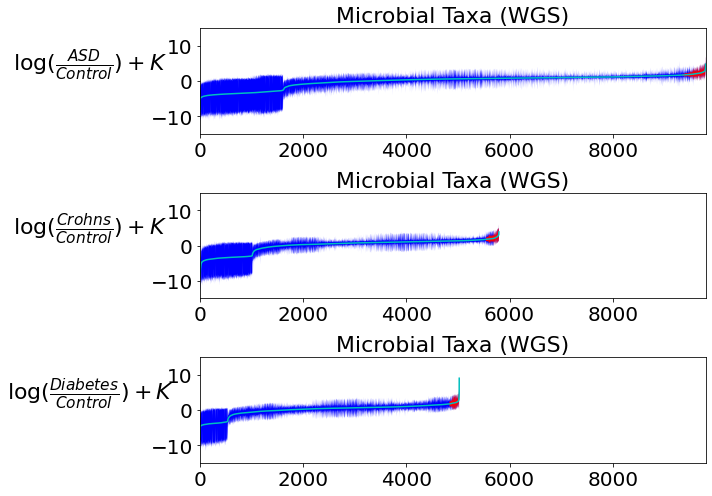

In [13]:
# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
wgs_ibd_stats = ranking(wgs_ibd_diffs, reference_percentile=95)
wgs_asd_stats = ranking(wgs_asd_diffs, reference_percentile=95)
wgs_dia_stats = ranking(wgs_dia_diffs, reference_percentile=95)

matplotlib.rcParams['text.usetex'] = False
# Plot the log-fold changes
#with plt.style.context('dark_background'):
fig, ax = plt.subplots(3, 1, figsize=(10, 7))
fs, ls = 22, 20

cap = max(map(len, [wgs_ibd_stats, wgs_dia_stats, wgs_asd_stats]))

rankplot(wgs_asd_stats, ax[0])
ax[0].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[0].set_ylim([-15, 15])
ax[0].set_xlim([0, cap])
ax[0].set_ylabel(r'$\log(\frac{ASD}{Control})+K$', fontsize=fs, labelpad=60)
ax[0].tick_params(axis='x', labelsize=ls)
ax[0].tick_params(axis='y', labelsize=ls)

rankplot(wgs_ibd_stats, ax[1])
ax[1].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[1].set_ylim([-15, 15])
ax[1].set_xlim([0, cap])
ax[1].set_ylabel(r'$\log(\frac{Crohns}{Control})+K$', fontsize=fs, labelpad=60)
ax[1].tick_params(axis='x', labelsize=ls)
ax[1].tick_params(axis='y', labelsize=ls)

rankplot(wgs_dia_stats, ax[2])
ax[2].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[2].set_ylim([-15, 15])
ax[2].set_xlim([0, cap])
ax[2].set_ylabel(r'$\log(\frac{Diabetes}{Control})+K$', fontsize=fs, labelpad=60)
ax[2].tick_params(axis='x', labelsize=ls)
ax[2].tick_params(axis='y', labelsize=ls)

plt.tight_layout()

Filter out multi-mapped reads

In [14]:
# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
wgs_ibd_stats = ranking(wgs_ibd_diffs, reference_percentile=95)
wgs_asd_stats = ranking(wgs_asd_diffs, reference_percentile=95)
wgs_dia_stats = ranking(wgs_dia_diffs, reference_percentile=95)

# After

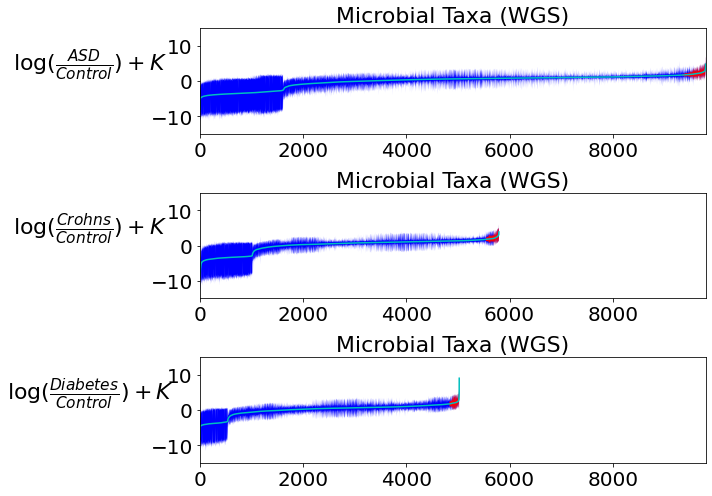

In [15]:
matplotlib.rcParams['text.usetex'] = False
# Plot the log-fold changes
#with plt.style.context('dark_background'):
fig, ax = plt.subplots(3, 1, figsize=(10, 7))
fs, ls = 22, 20

cap = max(map(len, [wgs_ibd_stats, wgs_dia_stats, wgs_asd_stats]))

rankplot(wgs_asd_stats, ax[0])
ax[0].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[0].set_ylim([-15, 15])
ax[0].set_xlim([0, cap])
ax[0].set_ylabel(r'$\log(\frac{ASD}{Control})+K$', fontsize=fs, labelpad=60)
ax[0].tick_params(axis='x', labelsize=ls)
ax[0].tick_params(axis='y', labelsize=ls)

rankplot(wgs_ibd_stats, ax[1])
ax[1].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[1].set_ylim([-15, 15])
ax[1].set_xlim([0, cap])
ax[1].set_ylabel(r'$\log(\frac{Crohns}{Control})+K$', fontsize=fs, labelpad=60)
ax[1].tick_params(axis='x', labelsize=ls)
ax[1].tick_params(axis='y', labelsize=ls)

rankplot(wgs_dia_stats, ax[2])
ax[2].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[2].set_ylim([-15, 15])
ax[2].set_xlim([0, cap])
ax[2].set_ylabel(r'$\log(\frac{Diabetes}{Control})+K$', fontsize=fs, labelpad=60)
ax[2].tick_params(axis='x', labelsize=ls)
ax[2].tick_params(axis='y', labelsize=ls)

plt.tight_layout()

# Compare different diseases

In [16]:
len(wgs_ibd_stats), len(wgs_dia_stats), len(wgs_asd_stats)

(5795, 5027, 9799)

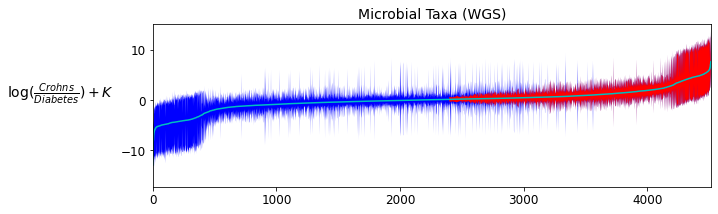

In [18]:
common_taxa = list(set(wgs_dia_diffs.index) & set(wgs_ibd_diffs.index))
ibd_dia_diffs = wgs_ibd_diffs.loc[common_taxa] - wgs_dia_diffs.loc[common_taxa]
ibd_dia_stats = ranking(ibd_dia_diffs, reference_percentile=50)

fig, ax = plt.subplots(figsize=(10, 3))
fs, ls = 14, 12
rankplot(ibd_dia_stats, ax)
ax.set_title('Microbial Taxa (WGS)', fontsize=fs)
#ax.set_ylim([-15, 15])
ax.set_xlim([0, len(ibd_dia_stats)])
ax.set_ylabel(r'$\log(\frac{Crohns}{Diabetes})+K$', fontsize=fs, labelpad=60)
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

In [21]:
ibd_i = np.logical_and(wgs_ibd_stats['tstat'] > 0, wgs_ibd_stats['pvalue'] < 0.05)
dia_i = np.logical_and(wgs_dia_stats['tstat'] > 0, wgs_dia_stats['pvalue'] < 0.05)
asd_i = np.logical_and(wgs_asd_stats['tstat'] > 0, wgs_asd_stats['pvalue'] < 0.05)

ibd_top_taxa = wgs_ibd_stats.loc[ibd_i].index
dia_top_taxa = wgs_dia_stats.loc[dia_i].index
asd_top_taxa = wgs_asd_stats.loc[asd_i].index

all_top_taxa = set(ibd_top_taxa) & set(dia_top_taxa) & set(asd_top_taxa)

Let's see how the overlap varies with respect to the percentile

In [22]:
stats = {}
for p in np.linspace(50, 100, 50):
    a = ranking(wgs_asd_diffs, reference_percentile=p)
    t = ranking(wgs_dia_diffs, reference_percentile=p)
    i = ranking(wgs_ibd_diffs, reference_percentile=p)
    
    asd_idx = np.logical_and(a['pvalue'] < 0.05, a['tstat'] > 0.0)
    ibd_idx = np.logical_and(i['pvalue'] < 0.05, i['tstat'] > 0.0)
    dia_idx = np.logical_and(t['pvalue'] < 0.05, t['tstat'] > 0.0)

    asd_taxa = set(a.loc[asd_idx].index)
    dia_taxa = set(t.loc[dia_idx].index)
    ibd_taxa = set(i.loc[ibd_idx].index)
    ati = len(asd_taxa & dia_taxa & ibd_taxa)
    at = len(asd_taxa & dia_taxa)
    ai = len(asd_taxa & ibd_taxa)
    ti = len(dia_taxa & ibd_taxa)
    stats[p] = (ati, at, ai, ti, np.sum(asd_idx), np.sum(dia_idx), np.sum(ibd_idx)) 
stats = pd.DataFrame(stats, index=['common', 'asd_t1d', 'asd_ibd', 't1d_ibd', 
                                   'asd', 't1d', 'ibd']).T

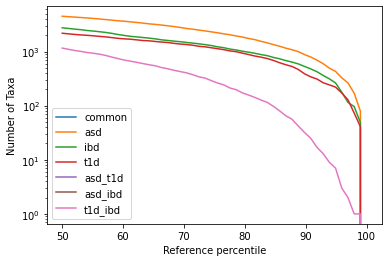

In [23]:
plt.plot(stats.index, stats['common'], label='common')
plt.plot(stats.index, stats['asd'], label='asd')
plt.plot(stats.index, stats['ibd'], label='ibd')
plt.plot(stats.index, stats['t1d'], label='t1d')
plt.plot(stats.index, stats['asd_t1d'], label='asd_t1d')
plt.plot(stats.index, stats['asd_ibd'], label='asd_ibd')
plt.plot(stats.index, stats['t1d_ibd'], label='t1d_ibd')
plt.yscale('log')

plt.xlabel('Reference percentile')
plt.ylabel('Number of Taxa')
plt.legend()

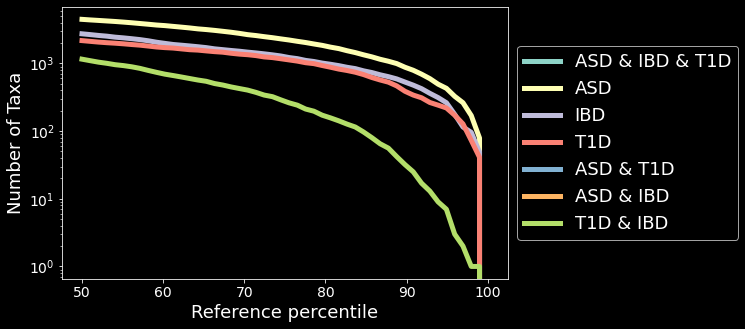

In [24]:
fs = 18
lw = 5
ls = 14
plt.rcParams['text.usetex'] = False

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(stats.index, stats['common'], label='ASD & IBD & T1D', lw=lw)
    ax.plot(stats.index, stats['asd'], label='ASD', lw=lw)
    ax.plot(stats.index, stats['ibd'], label='IBD', lw=lw)
    ax.plot(stats.index, stats['t1d'], label='T1D', lw=lw)
    ax.plot(stats.index, stats['asd_t1d'], label='ASD & T1D', lw=lw)
    ax.plot(stats.index, stats['asd_ibd'], label='ASD & IBD', lw=lw)
    ax.plot(stats.index, stats['t1d_ibd'], label='T1D & IBD', lw=lw)
    ax.set_yscale('log')

    ax.set_xlabel('Reference percentile', fontsize=fs)
    ax.set_ylabel('Number of Taxa', fontsize=fs)
    ax.tick_params(axis='x', labelsize=ls)
    ax.tick_params(axis='y', labelsize=ls)
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

In [ ]:
break

Look at the overlap at the 90% percentile

In [ ]:
ibd_i.sum(), dia_i.sum(), asd_i.sum()

In [ ]:
wgs_ibd_stats.shape, wgs_dia_stats.shape, wgs_asd_stats.shape

In [ ]:
len(ibd_top_taxa), len(dia_top_taxa), len(asd_top_taxa)

In [ ]:
len(all_top_taxa)

Identify midpoint taxa

In [ ]:
from scipy.stats import ttest_1samp
def midpoint_test(x):
    """ Tests if microbe is significantly overlapping with zero"""
    x = x - x.mean(axis=0)   # CLR transform posterior
    return x.apply(lambda z: ttest_1samp(z, 0)[1], axis=1)

asd_ibd_mid_pvals = midpoint_test(asd_ibd_diffs)
asd_dia_mid_pvals = midpoint_test(asd_dia_diffs)
ibd_dia_mid_pvals = midpoint_test(ibd_dia_diffs)

# test if posterior distribution includes zero
asd_ibd_idx = asd_ibd_mid_pvals < 0.05 / len(asd_ibd_mid_pvals)
asd_dia_idx = asd_dia_mid_pvals < 0.05 / len(asd_dia_mid_pvals)
ibd_dia_idx = ibd_dia_mid_pvals < 0.05 / len(ibd_dia_mid_pvals)

asd_ibd_mid_taxa = asd_ibd_idx.loc[asd_ibd_idx].index
asd_dia_mid_taxa = asd_dia_idx.loc[asd_dia_idx].index
ibd_dia_mid_taxa = ibd_dia_idx.loc[ibd_dia_idx].index

mid_taxa = set(asd_ibd_mid_taxa) & set(asd_dia_mid_taxa) & set(ibd_dia_mid_taxa)

In [ ]:
len(mid_taxa)

In [ ]:
common_disease_taxa = list(set(all_top_taxa & mid_taxa))

In [ ]:
len(common_disease_taxa)

In [ ]:
select_taxa = mapping.set_index('genome').loc[common_disease_taxa]

In [ ]:
select_taxa = select_taxa.sort_values(['phylum', 'class', 'order', 'family', 'genus'])

In [ ]:
select_taxa.to_csv('../results/core_disease_taxa.csv')

In [ ]:
mapping = mapping.set_index('genome')

In [ ]:
wgs_ibd_stats = pd.merge(wgs_ibd_stats, mapping, left_index=True, right_index=True)
wgs_dia_stats = pd.merge(wgs_dia_stats, mapping, left_index=True, right_index=True)
wgs_asd_stats = pd.merge(wgs_asd_stats, mapping, left_index=True, right_index=True)

wgs_ibd_stats.loc[ibd_i].to_csv('../results/top_ibd_taxa.csv')
wgs_dia_stats.loc[dia_i].to_csv('../results/top_diabetes_taxa.csv')
wgs_asd_stats.loc[asd_i].to_csv('../results/top_asd_taxa.csv')

In [ ]:
wgs_ibd_stats.shape, wgs_dia_stats.shape, wgs_asd_stats.shape

In [ ]:
font = {'size': 14}
matplotlib.rc('font', **font)
out = venn3([set(wgs_ibd_stats.loc[ibd_i].index),
             set(wgs_dia_stats.loc[dia_i].index),
             set(wgs_asd_stats.loc[asd_i].index)], ['IBD', 'T1D', 'ASD'])

for text in out.set_labels:
    text.set_fontsize(16)
    
for test in out.subset_labels:
    text.set_fontsize(16)

In [ ]:
ibd_taxa = set(wgs_ibd_stats.loc[ibd_i].index)
t1d_taxa = set(wgs_dia_stats.loc[dia_i].index)
asd_taxa = set(wgs_asd_stats.loc[asd_i].index)

In [ ]:
asd_ibd = list(asd_taxa & ibd_taxa - t1d_taxa)
len(asd_ibd)

In [ ]:
asd_t1d = list(asd_taxa & t1d_taxa - ibd_taxa)
len(asd_t1d)

In [ ]:
asd_ = list(asd_taxa - (t1d_taxa | ibd_taxa))
len(asd_)

In [ ]:
wgs_asd_stats.loc[asd_].head(50)

In [ ]:
ibd_t1d = list(ibd_taxa & t1d_taxa - asd_taxa)
len(ibd_t1d)

In [ ]:
ibd_ = list(ibd_taxa - (t1d_taxa | asd_taxa))
len(ibd_)

In [ ]:
t1d_ = list(t1d_taxa - (ibd_taxa | asd_taxa))
len(t1d_)

In [ ]:
core = list(t1d_taxa & ibd_taxa & asd_taxa)
len(core)

In [ ]:
union = list(t1d_taxa | ibd_taxa | asd_taxa)
len(union)

In [ ]:
asd_not = list(set(union) - asd_taxa)
len(asd_not)

In [ ]:
ibd_not = list(set(union) - ibd_taxa)
len(ibd_not)

In [ ]:
t1d_not = list(set(union) - t1d_taxa)
len(t1d_not)

In [ ]:
asd_ibd_not = list(set(union) - set(asd_ibd))
len(asd_ibd_not)

In [ ]:
asd_t1d_not = list(set(union) - set(asd_t1d))
len(asd_t1d_not)

In [ ]:
ibd_t1d_not = list(set(union) - set(ibd_t1d))
len(ibd_t1d_not)

In [ ]:
comparisons = {
    'asd_': 'asd_not',
    'ibd_': 'ibd_not',
    't1d_': 't1d_not',
    'asd_ibd': 'asd_ibd_not',
    'asd_t1d': 'asd_t1d_not',
    'ibd_t1d': 'ibd_t1d_not'
}

In [ ]:
set_names = ['core', 't1d_', 'ibd_', 'asd_', 'asd_ibd', 'asd_t1d', 'ibd_t1d']
for sname in set_names:
    s = locals()[sname]
    #print(len(s))
    mapping.loc[s].to_csv(f'../results/{sname}_taxa_set.csv')
    print(len(mapping.loc[s]))

In [ ]:
mapping.loc[asd_]

In [ ]:
mapping.loc[s]

In [ ]:
sname = set_names[0]

# KEGG annotations

Merge all KEGG tables

In [ ]:
ko_ogu_asd = get_genomic_data(f'{wgs_asd_directory}/table_func.biom')
ko_ogu_ibd = get_genomic_data('../sfari/data/sra_ibd_shotgun/Lloyd_Price2019/bioms/ogus_func.biom')
ko_ogu_t1d = get_genomic_data('../sfari/data/diaimmune/106364_per-gene.biom', lookup['genome'].to_dict())

all_taxa_ids = list(set(ko_ogu_asd.index) | set(ko_ogu_ibd.index) | set(ko_ogu_t1d.index))
all_kegg_ids = list(set(ko_ogu_asd.columns) | set(ko_ogu_ibd.columns) | set(ko_ogu_t1d.columns))
ko_ogu_asd = ko_ogu_asd.reindex(index=all_taxa_ids, columns=all_kegg_ids).fillna(0)
ko_ogu_ibd = ko_ogu_ibd.reindex(index=all_taxa_ids, columns=all_kegg_ids).fillna(0)
ko_ogu_t1d = ko_ogu_t1d.reindex(index=all_taxa_ids, columns=all_kegg_ids).fillna(0)

ko_ogu = ko_ogu_asd + ko_ogu_ibd + ko_ogu_t1d

In [ ]:
# Collect KEGGs per microbe
kegg_ogu_mapping = ko_ogu.reset_index().melt(
    id_vars='index', value_name='copy_number', var_name='KEGG'
).set_index('index')
kegg_ogu_mapping = pd.merge(kegg_ogu_mapping, mapping, left_index=True, right_index=True)

Obtain plots for all of the KEGGs

In [ ]:
len(set(mapping.index) & set(all_taxa_ids)), len(mapping.index), len(all_taxa_ids)

Filter KEGGs based on binomial test

In [ ]:
# Perform binomial test on WGS data to determine uniquely identifying genes
all_taxa = set(mapping.index) & set(all_taxa_ids)
kegg_dict = {}
set_names2 = [
    'core', 
    't1d_', 'ibd_', 'asd_', 'asd_ibd', 'asd_t1d', 'ibd_t1d',
    't1d_not', 'ibd_not', 'asd_not', 'asd_ibd_not', 'asd_t1d_not', 'ibd_t1d_not',
]

for sname in set_names2:
    s = locals()[sname]
    staxa = set(s)
    pos, neg = list(set(all_taxa & staxa)), list(all_taxa - staxa)
    wgs_pos = mapping.loc[pos]
    wgs_neg = mapping.loc[neg]
    kegg_pos_wgs = ko_ogu.align(wgs_pos, axis=0, join='inner')[0]
    kegg_neg_wgs = ko_ogu.align(wgs_neg, axis=0, join='inner')[0]
    kegg_neg_wgs, kegg_pos_wgs, kegg_neg_p, kegg_pos_p = btest(
        kegg_neg_wgs, kegg_pos_wgs, return_proportions=True)
    kegg_pos_wgs = log_pvalue(kegg_pos_wgs, alpha=1e-3)
    kegg_pos_wgs = pd.merge(
        kegg_pos_wgs, pd.DataFrame({'proportion': (kegg_pos_p + 1) / (kegg_pos_p + 1).sum()}),
        left_on='KEGG', right_index=True)
    kegg_dict[sname] = kegg_pos_wgs

Aggregate filtered KEGGs to pathway level

In [ ]:
pwy_dict = {}
for sname in ['t1d_', 'ibd_', 'asd_', 'asd_ibd', 'asd_t1d', 'ibd_t1d']:
    set_ = kegg_dict[sname].set_index('KEGG')
    set_not = kegg_dict[comparisons[sname]].set_index('KEGG')
    set__core = pd.merge(set_['proportion'], set_not['proportion'], left_index=True, right_index=True)
    logxy = np.log(set__core['proportion_x'] / set__core['proportion_y'])
    idx = logxy.loc[logxy > 0].index
    sig_wgs = aggregate_pathways(
        pathway_name_file=f'{kegg_dir}/pathway_name.txt',
        pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
        features=set_.loc[idx].reset_index())
    #sig_wgs = sig_wgs.set_index('KEGG')['Name'].drop_duplicates()
    pwy_counts = sig_wgs['Name'].value_counts()
    idx = list(map(lambda x: 'metabolism' in x, pwy_counts.index))
    pwy_dict[sname] = pwy_counts.loc[idx]

In [ ]:
fig, ax = plt.subplots(figsize=(8, 30))
pwy_summary = pd.DataFrame(pwy_dict)
pwy_summary = pwy_summary.loc[pwy_summary.var(axis=1) > 1]
pwy_summary = pwy_summary.reset_index().melt(
    id_vars='index', var_name='disease_intersection', value_name='KEGG_counts')
sns.barplot(data=pwy_summary, y='index', x='KEGG_counts', hue='disease_intersection', ax=ax)
ax.set_ylabel('')

In [ ]:
pwy_summary.to_csv('../results/kegg_counts.csv')

# Tripartite network

First, let's identify key metabolic pathways through a log-odds ranking

In [ ]:
pwy_summary = pd.DataFrame(pwy_dict)
pwy_summary = pwy_summary.loc[pwy_summary.var(axis=1) > 1].dropna()

asd_ibd = np.log(pwy_summary['asd_'] / pwy_summary['asd_ibd'])
asd_t1d = np.log(pwy_summary['asd_'] / pwy_summary['asd_t1d'])

In [ ]:
data = pd.DataFrame({'ASD/(ASD+IBD)': asd_ibd, 'ASD/(ASD+T1D)': asd_t1d})
data['diff'] = data['ASD/(ASD+IBD)'] - data['ASD/(ASD+T1D)']

In [ ]:
data.sort_values('diff')

Save KEGG associations for each taxon

# Parsing differential differentials

In [ ]:
#ibd_dia_stats = pd.merge(ibd_dia_stats, mapping, left_index=True, right_index=True)
#asd_ibd_stats = pd.merge(asd_ibd_stats, mapping, left_index=True, right_index=True)
#asd_dia_stats = pd.merge(asd_dia_stats, mapping, left_index=True, right_index=True)

ibd_dia_stats.to_csv('../results/ibd_diabetes_differential.csv')
asd_ibd_stats.to_csv('../results/asd_ibd_differential.csv')
asd_dia_stats.to_csv('../results/asd_diabetes_differential.csv')

In [ ]:
top_wgs_ibd_stats = wgs_ibd_stats.loc[ibd_i]
idx = list(set(top_wgs_ibd_stats.index) - set(common_disease_taxa))
top_wgs_ibd_stats = top_wgs_ibd_stats.loc[idx]

top_wgs_asd_stats = wgs_asd_stats.loc[asd_i]
idx = list(set(top_wgs_asd_stats.index) - set(common_disease_taxa))
top_wgs_asd_stats = top_wgs_asd_stats.loc[idx]

top_wgs_dia_stats = wgs_dia_stats.loc[dia_i]
idx = list(set(top_wgs_dia_stats.index) - set(common_disease_taxa))
top_wgs_dia_stats = top_wgs_dia_stats.loc[idx]

In [ ]:
top_wgs_ibd_stats.to_csv('../results/top_ibd_specific_taxa.csv')
top_wgs_asd_stats.to_csv('../results/top_asd_specific_taxa.csv')
top_wgs_dia_stats.to_csv('../results/top_dia_specific_taxa.csv')

In [ ]:
len(set(top_wgs_dia_stats.index) & set(top_wgs_asd_stats.index))

In [ ]:
idx = list(set(top_wgs_ibd_stats.index) & set(top_wgs_asd_stats.index))
mapping.loc[idx].to_csv('../results/top_ibd_asd_specific_taxa.csv')
idx = list(set(top_wgs_ibd_stats.index) & set(top_wgs_dia_stats.index))
mapping.loc[idx].to_csv('../results/top_ibd_dia_specific_taxa.csv')
idx = list(set(top_wgs_asd_stats.index) & set(top_wgs_dia_stats.index))
mapping.loc[idx].to_csv('../results/top_asd_dia_specific_taxa.csv')

In [ ]:
len(set(top_wgs_asd_stats.index) & set(top_wgs_ibd_stats.index)), len(top_wgs_ibd_stats), len(top_wgs_asd_stats)

In [ ]:
len(set(top_wgs_ibd_stats.index) & set(top_wgs_dia_stats.index)), len(top_wgs_ibd_stats), len(top_wgs_dia_stats)

In [ ]:
len(set(top_wgs_dia_stats.index) & set(top_wgs_asd_stats.index)), len(top_wgs_dia_stats), len(top_wgs_asd_stats)